<a href="https://colab.research.google.com/github/rkakamilan/test_cleanlab/blob/master/test_cleanlab_mnist_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cleanlab

     |████████████████████████████████| 61kB 2.3MB/s 


https://github.com/cgnorthcutt/cleanlab/blob/master/examples/mnist/label_errors_mnist_test_cnn.ipynb

In [0]:
# Python 2 and 3 compatibility
from __future__ import print_function, absolute_import, division, unicode_literals, with_statement

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch, torchvision
from cleanlab.models.mnist_pytorch import CNN, MNIST_TEST_SIZE, MNIST_TRAIN_SIZE
import cleanlab
import numpy as np
from PIL import Image

import sys
import os
import traceback
from datetime import datetime as dt
import copy

from sklearn.metrics import confusion_matrix, accuracy_score

# Important! Make fonts Type I fonts (necessary for publishing in ICML and other conference)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from torchvision import datasets

In [5]:
X_train = np.arange(MNIST_TRAIN_SIZE)
X_test = np.arange(MNIST_TEST_SIZE)
# X_train = X_train[X_train % 10 == 0]
# y_train = datasets.MNIST('../data', train=True).train_labels.numpy()
y_train = datasets.MNIST('../data', train=True, download=True).train_labels.numpy()
# y_test = datasets.MNIST('../data', train=False).test_labels.numpy()
y_test = datasets.MNIST('../data', train=False, download=True).test_labels.numpy()
py_train = cleanlab.util.value_counts(y_train) / float(len(y_train))
# X_test_data = datasets.MNIST('../data', train=False).test_data.numpy()
X_test_data = datasets.MNIST('../data', train=False, download=True).test_data.numpy()

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


## Finding label errors in MNIST test set

In [6]:
red_box_idxs = [947,5937,3520, 4163, 2597,9729, 4874, 3776] # 2130, 9642,449, 659]

def imshow(inp, img_labels=None, img_pred=None, img_fns = None, figsize=(10,10), normalize=False, red_boxes=True, savefig = False):
    """Imshow for Tensor."""
    height, width = inp.shape[1:]
    xbins = 8
    ybins = int(np.ceil(len(img_labels)/xbins))
    xbin_width = width // xbins
    ybin_height = height // ybins
    
    inp = inp.numpy().transpose((1, 2, 0))
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    
    ax = plt.figure(figsize=figsize).gca()
    ax.imshow(inp)
    pad_size = (8-len(img_pred)%8)%8
    img_labels = img_labels + ['']*pad_size #padding
    img_pred = img_pred + ['']*pad_size #padding
    img_fns = img_fns + ['']*pad_size #padding
#     grid = np.asarray(img_labels).reshape((ybins, xbins))
        
    num_red_boxes = 0
    for (j,i),idx in np.ndenumerate(np.arange(ybins*xbins).reshape((ybins, xbins))):
        prediction = img_pred[idx]
        label = img_labels[idx]
        img_fn = img_fns[idx]
        image_index = int(img_fn[13:])
        
        plt.hlines([j*ybin_height - .5], xmin=i*xbin_width, xmax=i*xbin_width + xbin_width, color = 'lightgray', linewidth=2)
        
        fontsize=max(min(1.4*figsize[0], .9*figsize[0]-.7*len(prediction)), 12) if prediction != '' else 1
        tt = ax.text(i*xbin_width + xbin_width/2,j*ybin_height + ybin_height/20,prediction,ha='center',va='center', fontsize=fontsize)
        tt.set_bbox(dict(facecolor='lime', alpha=0.8, edgecolor=None))
        
        fontsize=min(.5*figsize[0], 1.25*figsize[0]-len(img_fn)) if img_fn != '' else 1
        tt = ax.text(i*xbin_width + xbin_width/2.8,j*ybin_height + ybin_height/7,img_fn,ha='center',va='center', fontsize=fontsize)
        tt.set_bbox(dict(facecolor='lightgray', alpha=0.8, edgecolor=None))
        
        fontsize=max(min(1.4*figsize[0], .9*figsize[0]-.7*len(label)),12) if label != '' else 1
        t = ax.text(i*xbin_width + xbin_width/2,j*ybin_height + ybin_height/10*9,label,ha='center',va='center', fontsize=fontsize)
        t.set_bbox(dict(facecolor='cyan', alpha=0.8, edgecolor=None))
        
        if not red_boxes:
            plt.vlines([i*xbin_width + 0.5,(i+1)*xbin_width - 1.5], ymin=j*ybin_height + 0.5, ymax=j*ybin_height + ybin_height - 0.5, color = 'gray', linewidth=5)
        
        if red_boxes and image_index in red_box_idxs:
            # Draw red bounding box
            num_red_boxes += 1
            plt.hlines([j*ybin_height + 0.5,(j+1)*ybin_height - 1.5], xmin=i*xbin_width - 0.3, xmax=i*xbin_width + xbin_width - 0.65, color = 'red', linewidth=15)
            plt.vlines([i*xbin_width + 0.5,(i+1)*xbin_width - 1.5], ymin=j*ybin_height + 0.5, ymax=j*ybin_height + ybin_height - 0.5, color = 'red', linewidth=15)
            
        
    if red_boxes:
        print('Number of red boxes:', num_red_boxes)
    plt.axis('off')
    if savefig:
        plt.savefig('figs/mnist_test_label_errors'+str(len(img_labels))+'.pdf', pad_inches=0.0, bbox_inches='tight')
    plt.pause(0.001)  # pause a bit so that plots are updated

Train Epoch: 1 [0/10000 (0%)]	Loss: 2.299819
Train Epoch: 2 [0/10000 (0%)]	Loss: 1.304201
Train Epoch: 3 [0/10000 (0%)]	Loss: 0.936096
Train Epoch: 4 [0/10000 (0%)]	Loss: 0.545140
Train Epoch: 5 [0/10000 (0%)]	Loss: 0.521295
Train Epoch: 6 [0/10000 (0%)]	Loss: 0.302733
Train Epoch: 7 [0/10000 (0%)]	Loss: 0.501628
Train Epoch: 8 [0/10000 (0%)]	Loss: 0.326956
Train Epoch: 9 [0/10000 (0%)]	Loss: 0.269602
Train Epoch: 10 [0/10000 (0%)]	Loss: 0.275446
Train Epoch: 1 [0/8000 (0%)]	Loss: 0.263621
Train Epoch: 1 [0/8000 (0%)]	Loss: 0.412013
Train Epoch: 1 [0/8000 (0%)]	Loss: 0.214524
Train Epoch: 1 [0/8000 (0%)]	Loss: 0.276617
Train Epoch: 1 [0/8000 (0%)]	Loss: 0.296642
Number of estimated errors in test set: 31


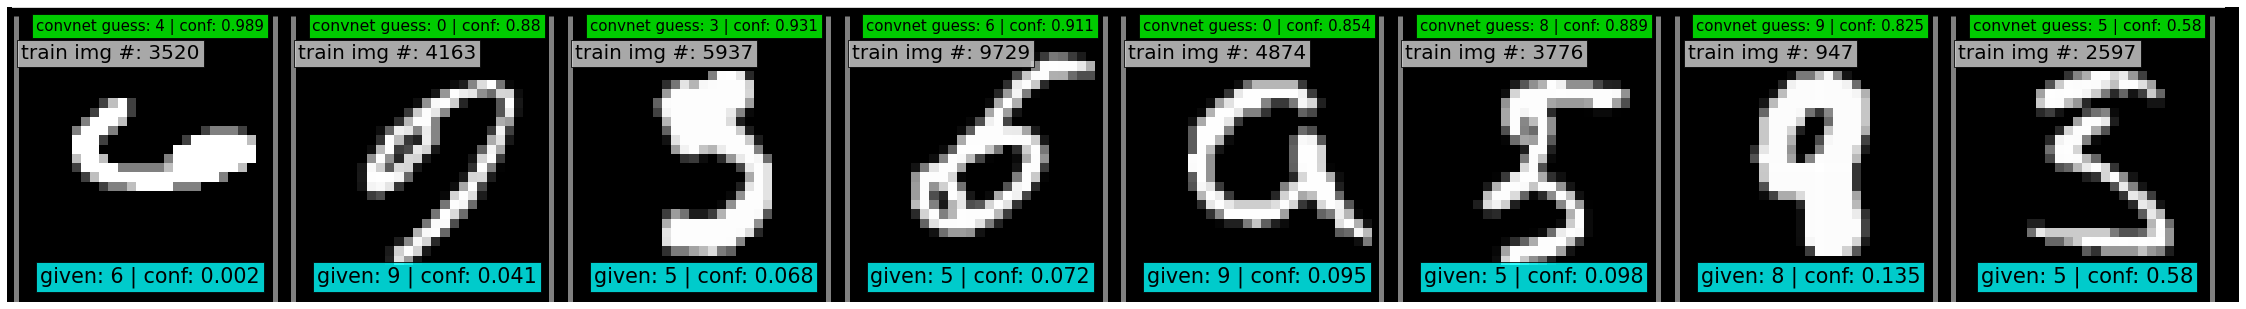

In [7]:
np.random.seed(43)
max_images = 8
savefig = False
prune_method = 'prune_by_noise_rate'

# Pre-train
cnn = CNN(epochs=10, log_interval=1000, loader='test') #pre-train
cnn.fit(X_test, y_test, loader='test') # pre-train (overfit, not out-of-sample) to entire dataset.

# Out-of-sample cross-validated holdout predicted probabilities
np.random.seed(4)
cnn.epochs = 1 # Single epoch for cross-validation (already pre-trained)
jc, psx = cleanlab.latent_estimation.estimate_confident_joint_and_cv_pred_proba(X_test, y_test, cnn)
est_py, est_nm, est_inv = cleanlab.latent_estimation.estimate_latent(jc, y_test)
# algorithmic identification of label errors
noise_idx = cleanlab.pruning.get_noise_indices(y_test, psx, est_inv, prune_method=prune_method) 
print('Number of estimated errors in test set:', sum(noise_idx))
noise_idx = np.asarray([i in red_box_idxs for i in range(len(y_test))]) # hand-picked digits from rankpruning alg's results
pred = np.argmax(psx, axis=1)

ordered_noise_idx = np.argsort(np.asarray([psx[i][j] for i,j in enumerate(y_test)])[noise_idx])

prob_given = np.asarray([psx[i][j] for i,j in enumerate(y_test)])[noise_idx][ordered_noise_idx][:max_images]
prob_pred = np.asarray([psx[i][j] for i,j in enumerate(pred)])[noise_idx][ordered_noise_idx][:max_images]
img_idx = np.arange(len(noise_idx))[noise_idx][ordered_noise_idx][:max_images]
label4viz = y_test[noise_idx][ordered_noise_idx][:max_images]
pred4viz = pred[noise_idx][ordered_noise_idx][:max_images]

graphic = torchvision.utils.make_grid(torch.from_numpy(np.concatenate([X_test_data[img_idx][:, None]]*3, axis=1)))
img_labels = ["given: "+str(label4viz[w])+" | conf: "+str(np.round(prob_given[w],3)) for w in range(len(label4viz))]
img_pred = ["convnet guess: "+str(pred4viz[w])+" | conf: "+str(np.round(prob_pred[w],3)) for w in range(len(pred4viz))]
img_fns = ["train img #: " + str(item) for item in img_idx]

# Display image
imshow(
    graphic, 
    img_labels = img_labels, 
    img_pred = img_pred, 
    img_fns = img_fns, 
    figsize=(40,max_images/1.1), 
    red_boxes = False,  
    savefig = savefig,
)
plt.show()

### Show that results generalize across epochs and seeds

Number of estimated errors in training set: 40
Epochs: 8 | Random seed: 15
Number of red boxes: 1


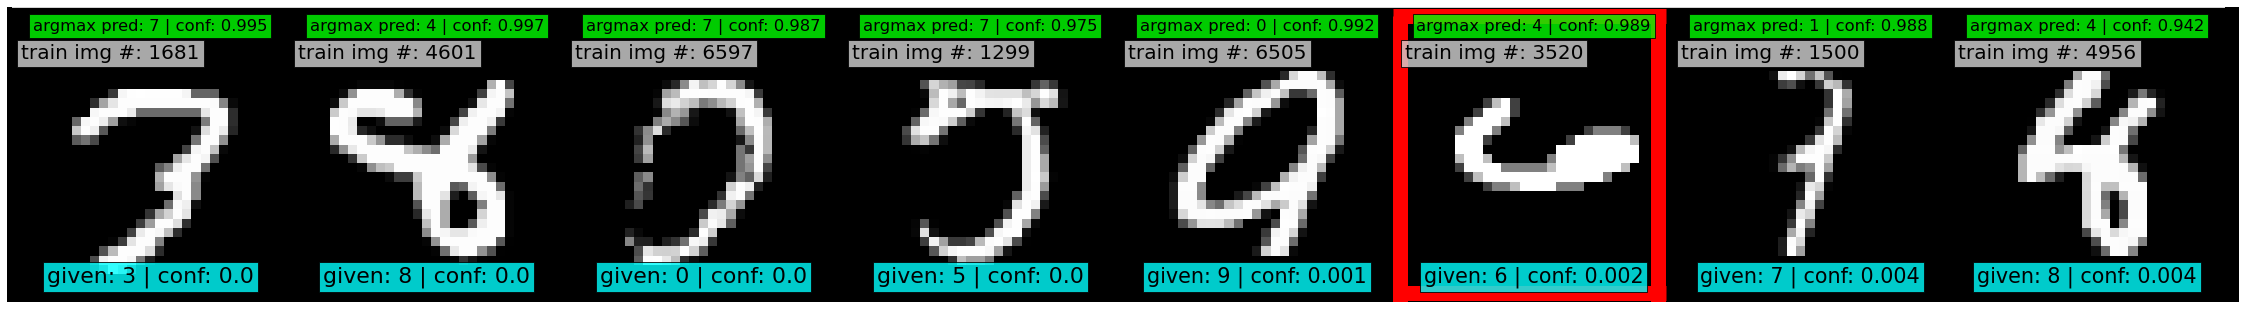

Epochs: 8 | Random seed: 15
Number of red boxes: 1


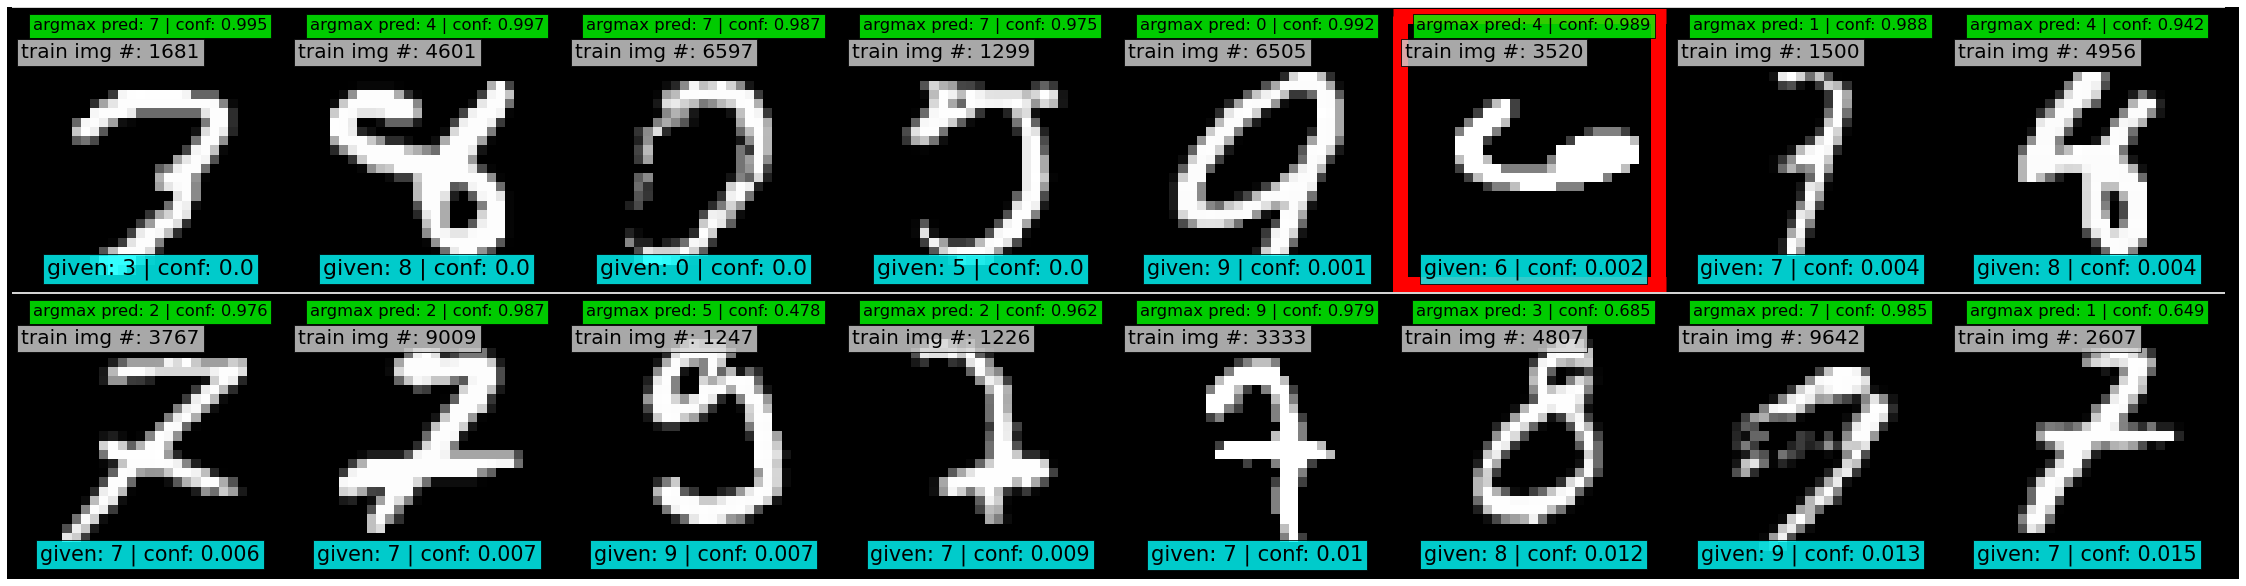

Number of estimated errors in training set: 20


/usr/local/lib/python3.6/dist-packages/cleanlab/pruning.py:358: RuntimeWarning: divide by zero encountered in true_divide
  tmp = (psy.T * num_to_remove_per_class / noise_per_s).T
/usr/local/lib/python3.6/dist-packages/cleanlab/pruning.py:358: RuntimeWarning: invalid value encountered in true_divide
  tmp = (psy.T * num_to_remove_per_class / noise_per_s).T


Epochs: 15 | Random seed: 14
Number of red boxes: 0


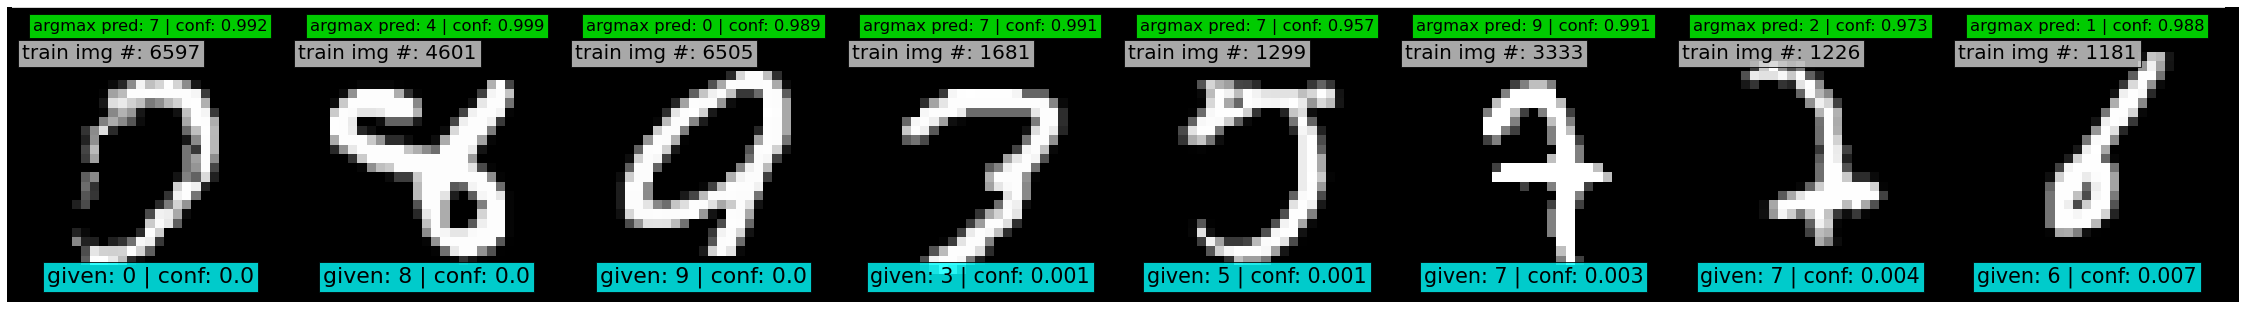

Epochs: 15 | Random seed: 14
Number of red boxes: 1


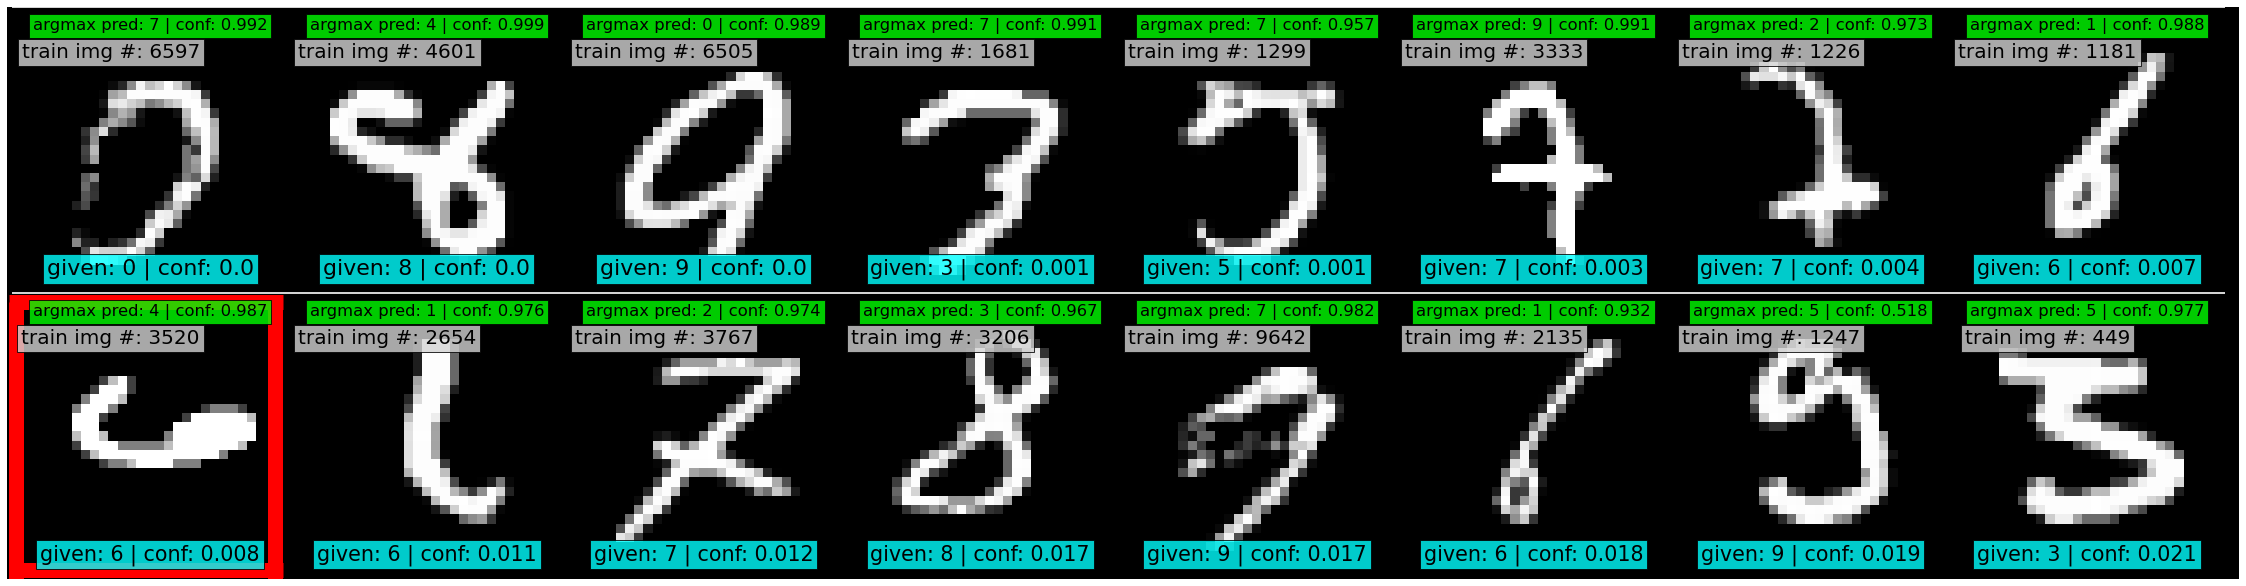

Number of estimated errors in training set: 33
Epochs: 10 | Random seed: 14
Number of red boxes: 1


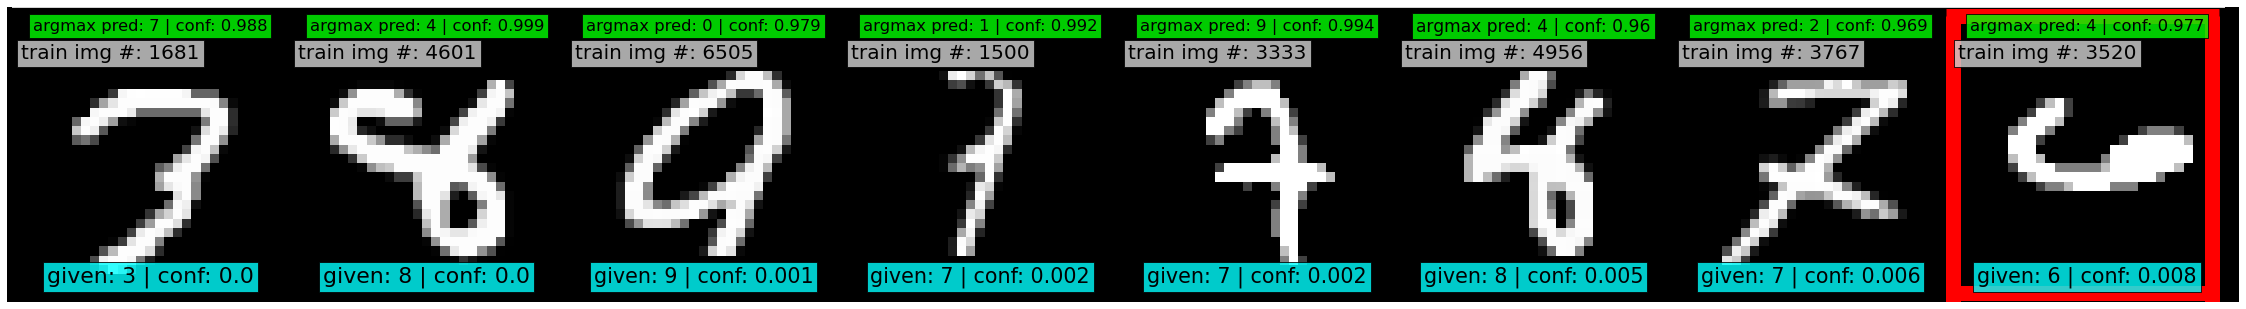

Epochs: 10 | Random seed: 14
Number of red boxes: 2


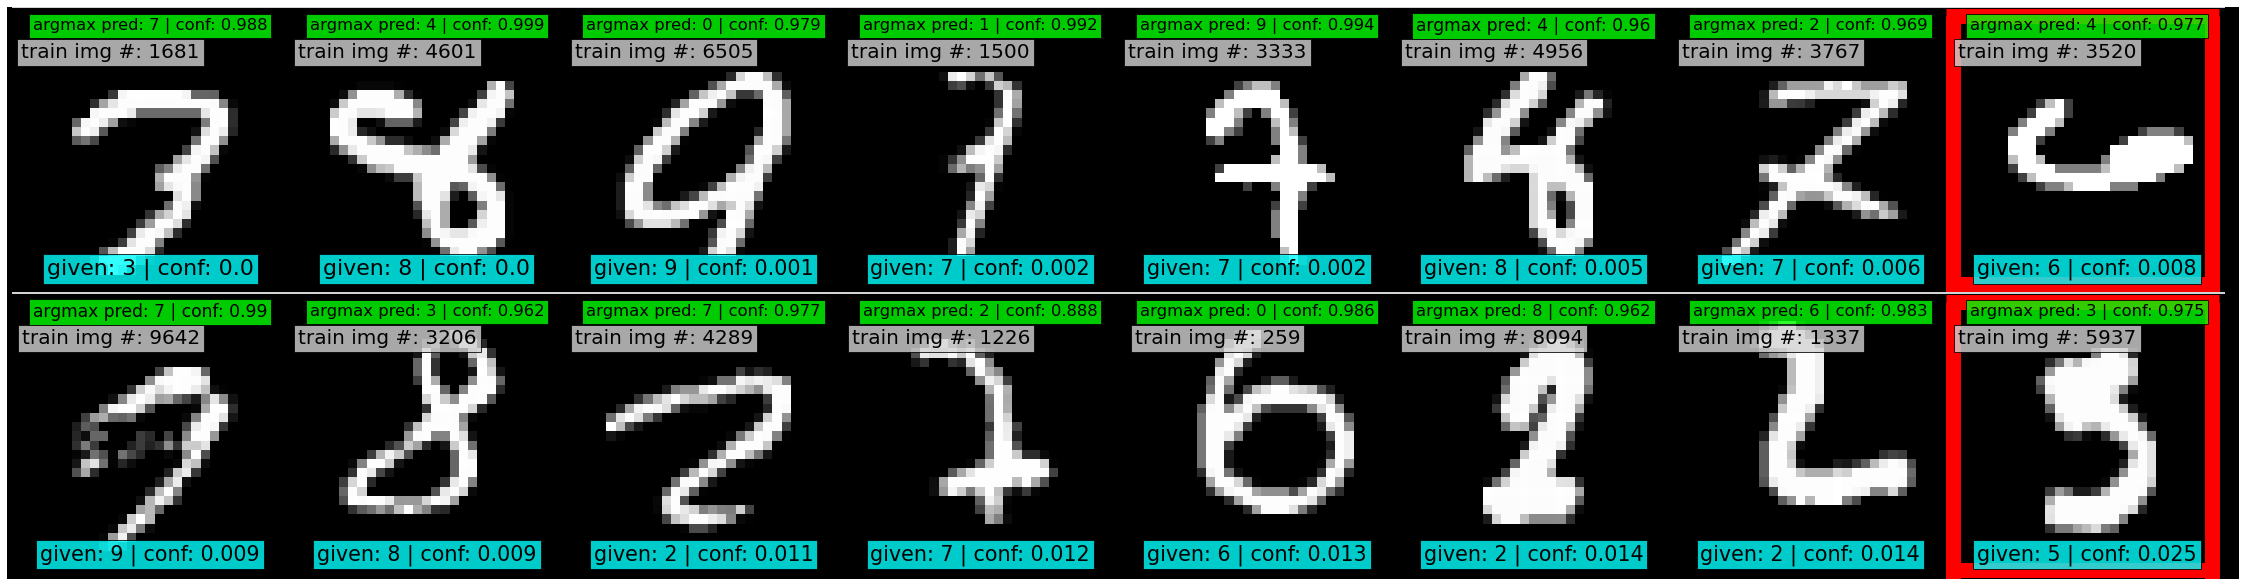

Number of estimated errors in training set: 12


/usr/local/lib/python3.6/dist-packages/cleanlab/pruning.py:358: RuntimeWarning: divide by zero encountered in true_divide
  tmp = (psy.T * num_to_remove_per_class / noise_per_s).T
/usr/local/lib/python3.6/dist-packages/cleanlab/pruning.py:358: RuntimeWarning: invalid value encountered in true_divide
  tmp = (psy.T * num_to_remove_per_class / noise_per_s).T


Epochs: 20 | Random seed: 13
Number of red boxes: 1


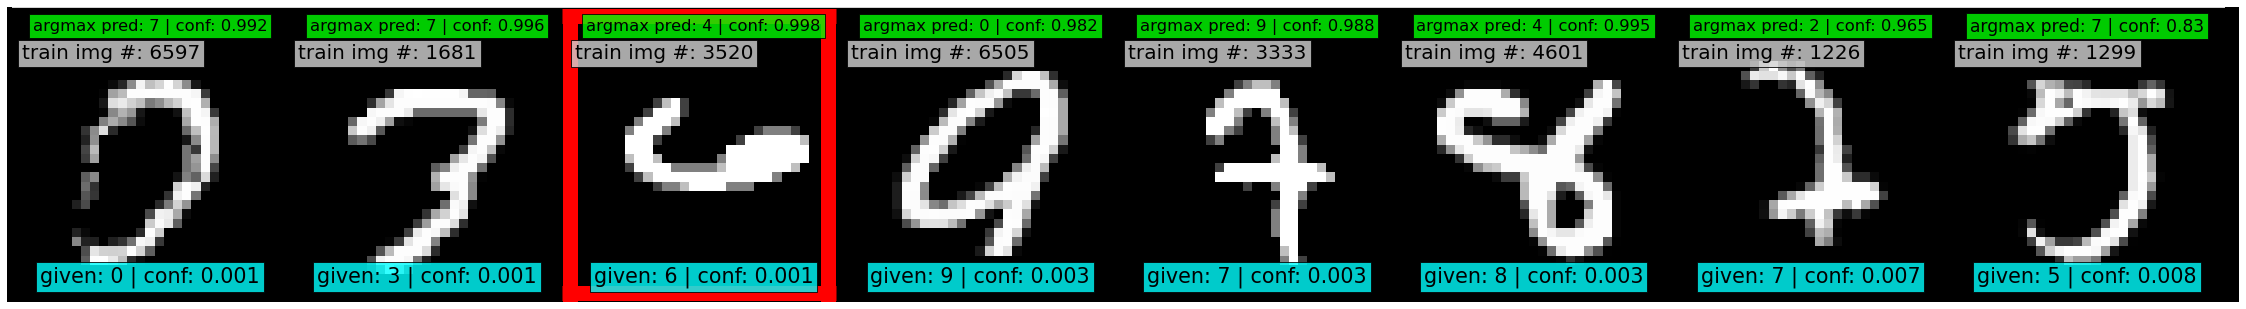

Epochs: 20 | Random seed: 13
Number of red boxes: 1


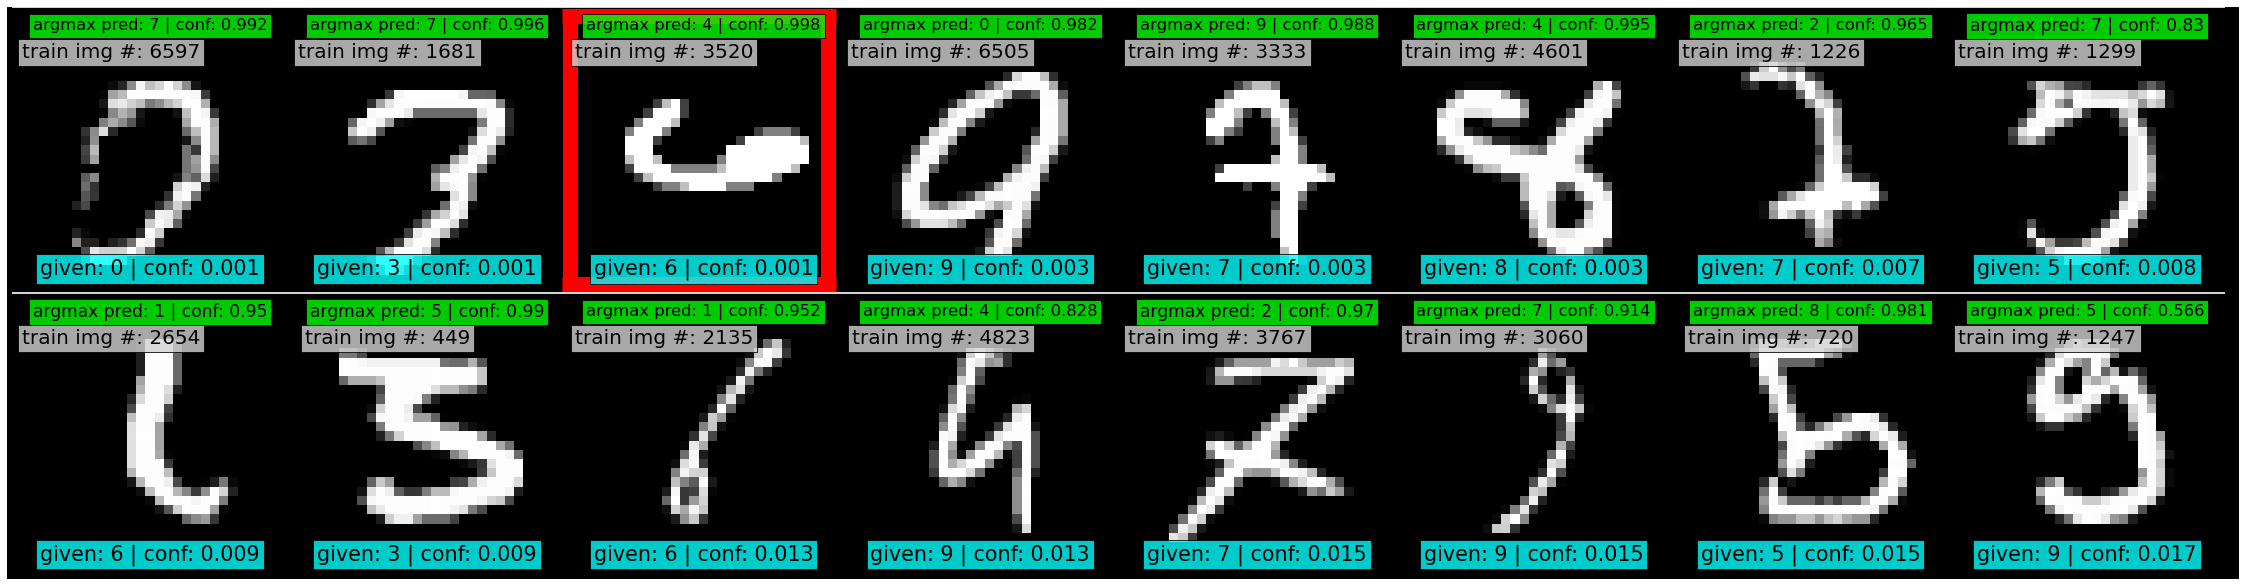

Number of estimated errors in training set: 36
Epochs: 8 | Random seed: 13
Number of red boxes: 1


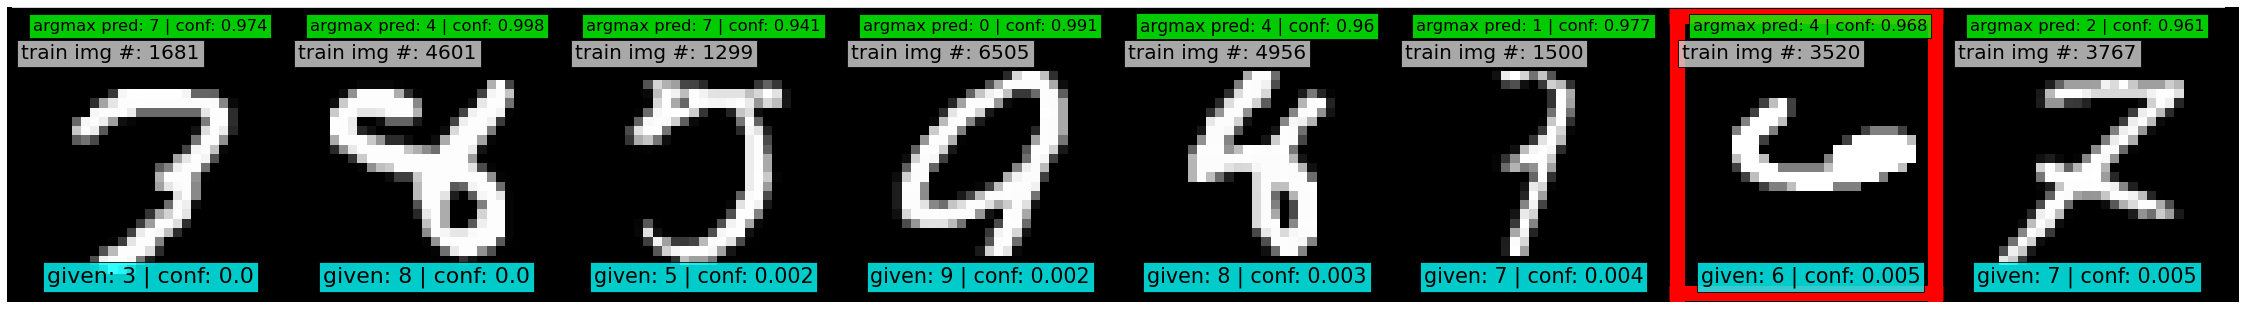

Epochs: 8 | Random seed: 13
Number of red boxes: 1


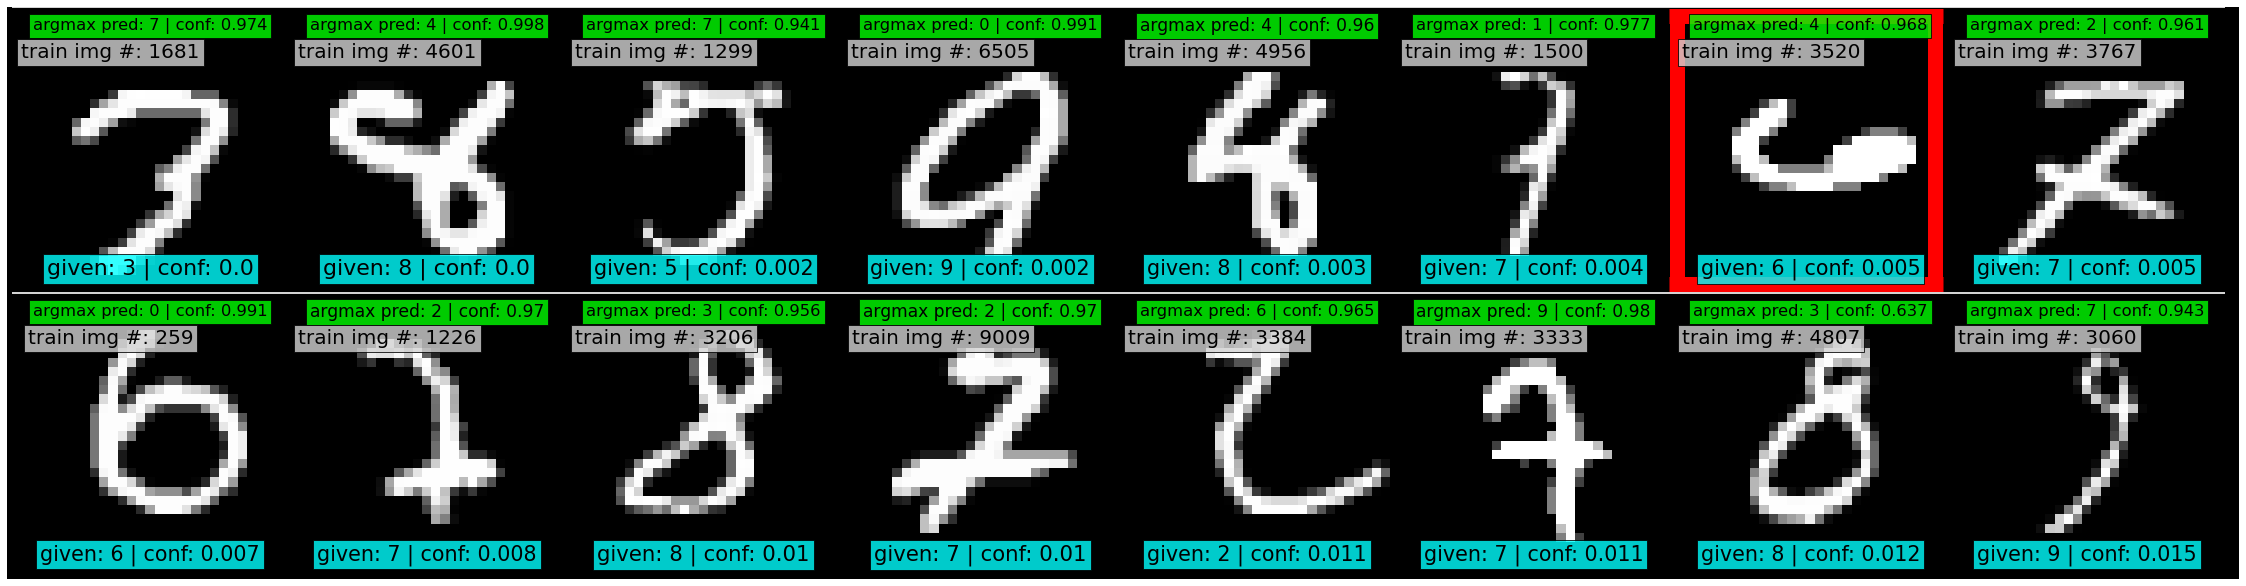

Number of estimated errors in training set: 30


/usr/local/lib/python3.6/dist-packages/cleanlab/pruning.py:358: RuntimeWarning: divide by zero encountered in true_divide
  tmp = (psy.T * num_to_remove_per_class / noise_per_s).T
/usr/local/lib/python3.6/dist-packages/cleanlab/pruning.py:358: RuntimeWarning: invalid value encountered in true_divide
  tmp = (psy.T * num_to_remove_per_class / noise_per_s).T


Epochs: 10 | Random seed: 12
Number of red boxes: 1


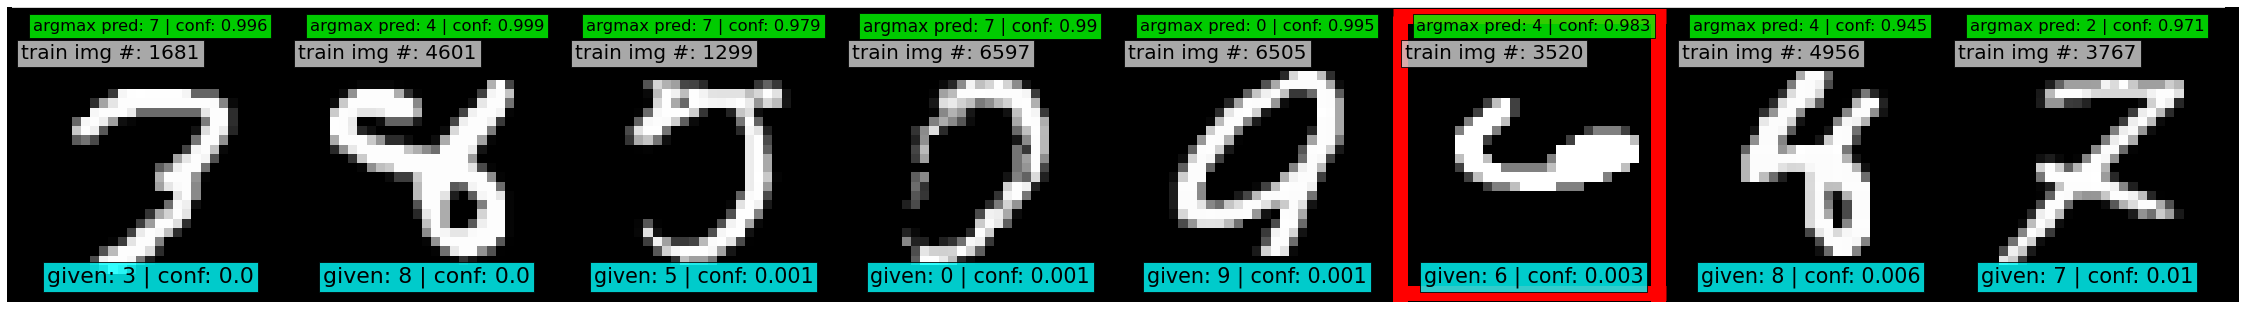

Epochs: 10 | Random seed: 12
Number of red boxes: 1


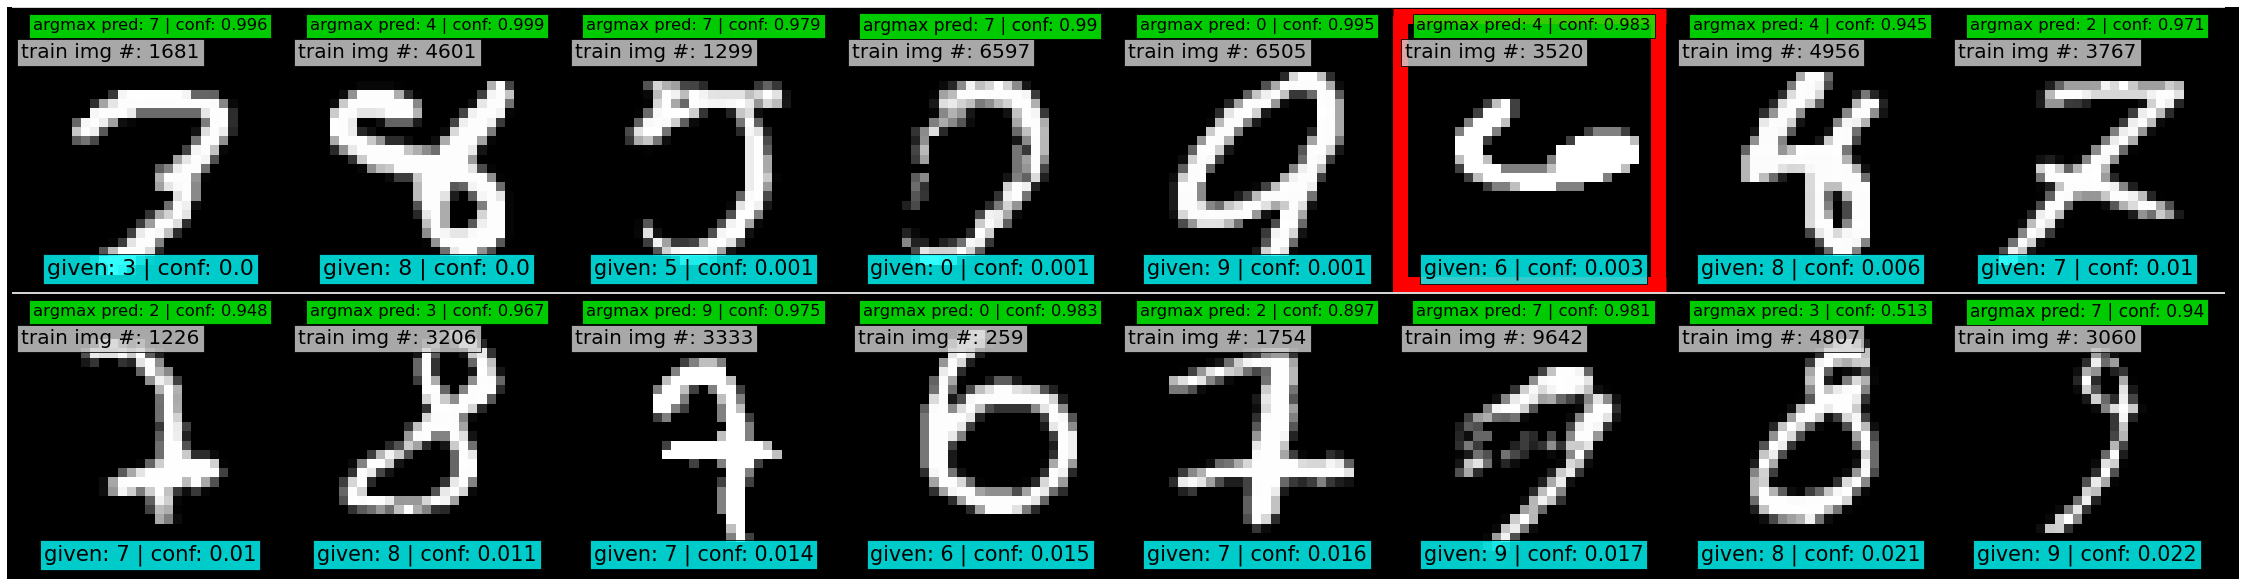

Number of estimated errors in training set: 40


/usr/local/lib/python3.6/dist-packages/cleanlab/pruning.py:358: RuntimeWarning: divide by zero encountered in true_divide
  tmp = (psy.T * num_to_remove_per_class / noise_per_s).T
/usr/local/lib/python3.6/dist-packages/cleanlab/pruning.py:358: RuntimeWarning: invalid value encountered in true_divide
  tmp = (psy.T * num_to_remove_per_class / noise_per_s).T


Epochs: 8 | Random seed: 12
Number of red boxes: 2


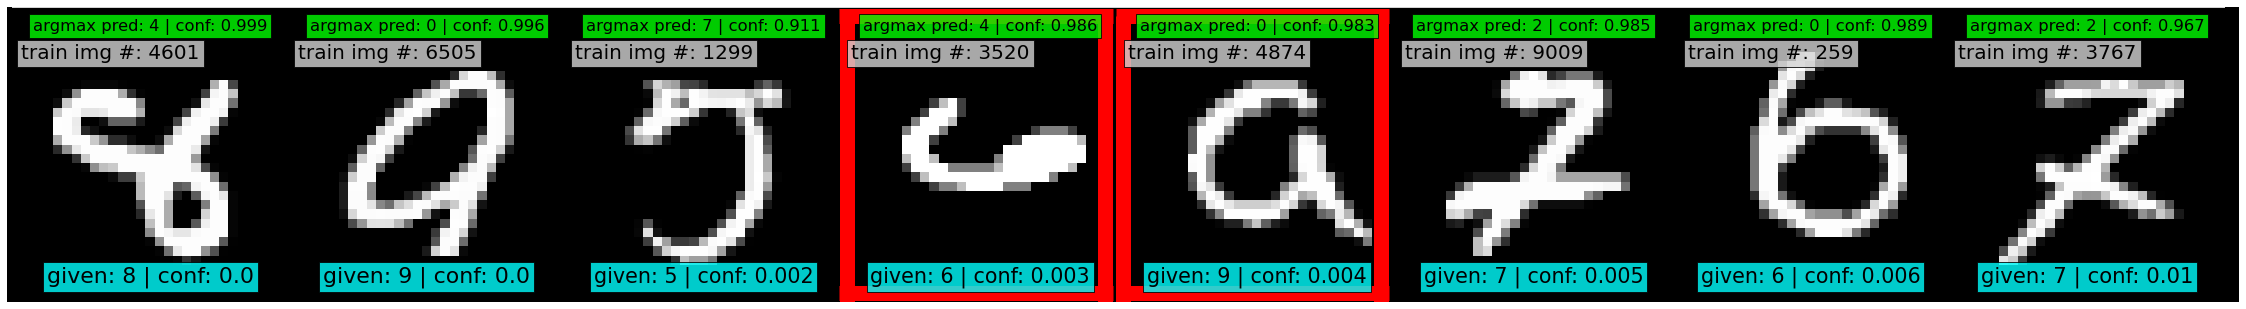

Epochs: 8 | Random seed: 12
Number of red boxes: 2


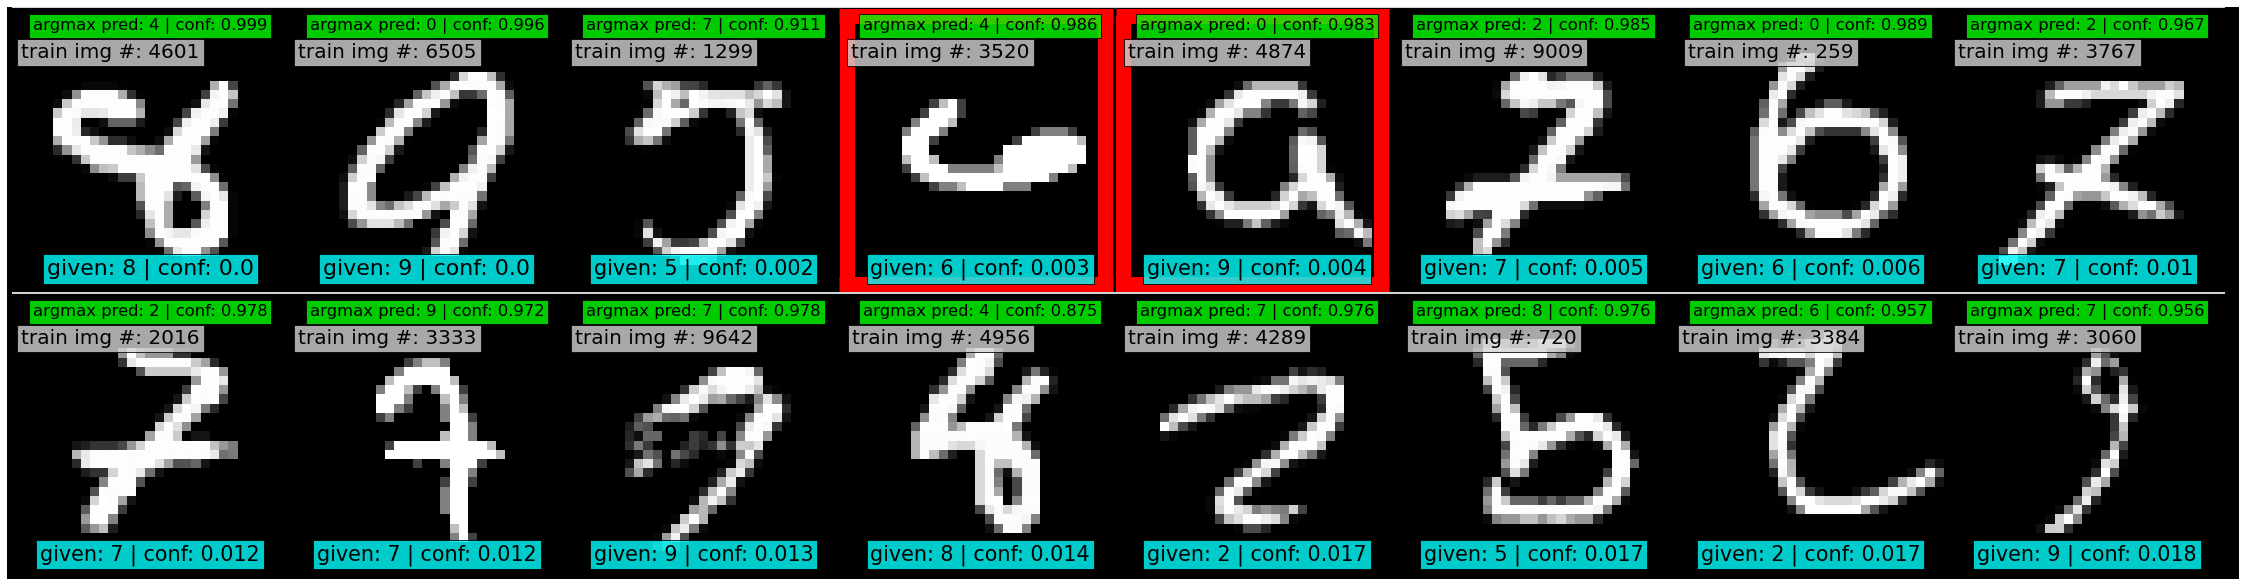

In [0]:
prune_method = 'prune_by_noise_rate'

# max_images = 24
for epochs, seed in [
    (8,15),
    (15,14),
    (10,14),
    (20,13),
    (8,13),
    (10,12),
    (8,12),
    (10,10),
    (8,9),
    (10,3),
    (10,2),
    (4,14),
    (3,13),
    (2,12),
]:
        # Pre-train
        np.random.seed(43)
        cnn = CNN(epochs=epochs, log_interval=None, loader='test') #pre-train
        cnn.fit(X_test, y_test, loader='test') # pre-train (overfit, not out-of-sample) to entire dataset.

        # Out-of-sample cross-validated holdout predicted probabilities
        np.random.seed(seed)
        cnn.epochs = 1 # Single epoch for cross-validation (already pre-trained)
        jc, psx = cleanlab.latent_estimation.estimate_confident_joint_and_cv_pred_proba(X_test, y_test, cnn)
        est_py, est_nm, est_inv = cleanlab.latent_estimation.estimate_latent(jc, y_test)
        # algorithmic identification of label errors
        noise_idx = cleanlab.pruning.get_noise_indices(y_test, psx, est_inv, prune_method=prune_method)
        print('Number of estimated errors in training set:', sum(noise_idx))
        noise_idx = cleanlab.pruning.get_noise_indices(y_test, psx, est_inv, prune_method=prune_method, num_to_remove_per_class=5)
        pred = np.argmax(psx, axis=1)

        for max_images in [8,16]:
            # Prepare and display figure ordered by lowest predicted probability
            if sum(noise_idx) >= max_images:
                print("Epochs:", epochs, "| Random seed:", seed)
                ordered_noise_idx = np.argsort(np.asarray([psx[i][j] for i,j in enumerate(y_test)])[noise_idx])

                prob_given = np.asarray([psx[i][j] for i,j in enumerate(y_test)])[noise_idx][ordered_noise_idx][:max_images]
                prob_pred = np.asarray([psx[i][j] for i,j in enumerate(pred)])[noise_idx][ordered_noise_idx][:max_images]
                img_idx = np.arange(len(noise_idx))[noise_idx][ordered_noise_idx][:max_images]
                label4viz = y_test[noise_idx][ordered_noise_idx][:max_images]
                pred4viz = pred[noise_idx][ordered_noise_idx][:max_images]

                graphic = torchvision.utils.make_grid(torch.from_numpy(np.concatenate([X_test_data[img_idx][:, None]]*3, axis=1)))
                # graphic = np.concatenate([graphic[:, None]]*3, axis=1)
                img_labels = ["given: "+str(label4viz[w])+" | conf: "+str(np.round(prob_given[w],3)) for w in range(len(label4viz))]
                img_pred = ["argmax pred: "+str(pred4viz[w])+" | conf: "+str(np.round(prob_pred[w],3)) for w in range(len(pred4viz))]
                img_fns = ["train img #: " + str(item) for item in img_idx]

                imshow(graphic, img_labels = img_labels, img_pred = img_pred, img_fns = img_fns, figsize=(40,max_images/1.1))
                plt.show()    